In [1]:
import control

import numpy as np
import matplotlib.pyplot as plt

from sympy.abc import t, s
from sympy import symbols, simplify, expand
from sympy.series import limit
from sympy import matrices
from sympy.integrals import integrate

# Problem 10.8

## Part a

Real PD:

 
$G(s) = k_c \left(\frac{1 + \tau_D s}{1 + \alpha \tau_D s}\right)$

$E(s)=\frac{1}{s}$

$U(s)=k_c\left(\frac{1+\tau_Ds}{s\left(1+\alpha\tau_Ds\right)}\right)$

$U(s)=k_c\left(\frac{1}{s}+\frac{\tau_D\left(1-\alpha\right)}{\left(1+\alpha\tau_Ds\right)}\right)$ 

$u(t)=k_c\left(1+\frac{\tau_D\left(1-\alpha\right)}{\alpha\tau_D}\right)\exp\left(-\alpha^{-1}\frac{t}{\tau_D}\right)$

Real PD response:

$$\frac{u(t)}{k_c}=1+\frac{\left(1-\alpha\right)}{\alpha}\exp\left(-\alpha^{-1}\frac{t}{\tau_D}\right)$$

Ideal PD:


$G(s)=k_c\left(1+\tau_Ds\right)$

$U(s)=k_c\left(\frac{1}{s}+\tau_D\right)$

Ideal PD response:

$$\frac{u(t)}{k_c}=1+\delta\left(t\right)$$

### Simulation

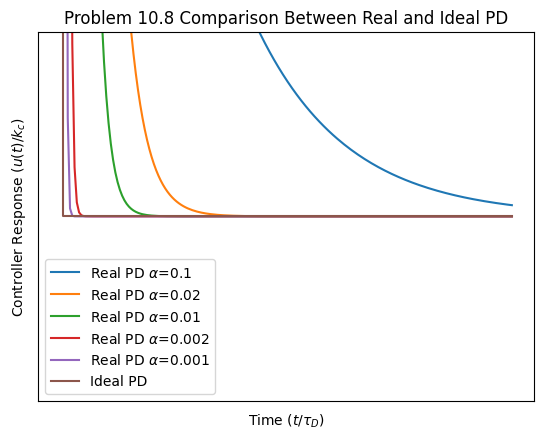

In [9]:
alpha = [0.1, 2e-2, 1e-2, 2e-3, 1e-3]

def real_pd(t, alpha):
    return 1 + (1 - alpha) / alpha * np.exp(-t / alpha)

t_values = np.linspace(0, .5, 200)

for a in alpha:
    plt.plot(t_values, real_pd(t_values, a), label=r"Real PD $\alpha$="+f"{a}")

ideal_pd_response = np.ones(t_values.shape[0])
ideal_pd_response[0] = 1e300

plt.plot(t_values, ideal_pd_response, label="Ideal PD")

plt.ylim([0, 2])
plt.xlabel(r"Time ($t/\tau_D$)")
plt.ylabel(r"Controller Response ($u(t)/k_c$)")
plt.title("Problem 10.8 Comparison Between Real and Ideal PD")
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

The closer that $\alpha$ is to zero, the closer closer that the Real PD is to the Ideal PD. The smaller the $\alpha$ value, the faster that the Real PD reaches the set point.

## Part B

Real PD:

$$G(s)=k_c\left(\frac{1+\tau_Ds}{1+\alpha\tau_Ds}\right)$$

Ideal PD:

$$G(s)=k_c\left(1+\tau_Ds\right)$$

### Bode Diagrams

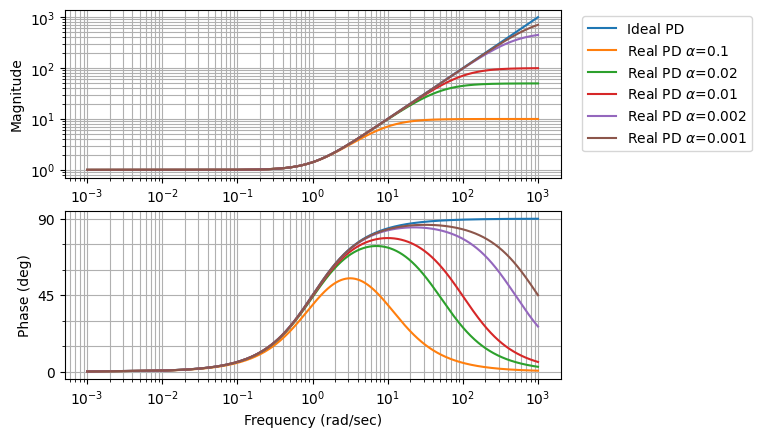

In [3]:
# alpha = [0.1, 0.02, 0.01, 0.005, 0.005/2, 1e-6]
ideal_pd = control.tf([1, 1], [1])

w = np.linspace(1e-3, 1e3, int(1e5))

mag, phase, omega = control.bode_plot(ideal_pd, omega=w, wrap_phase=True, label="Ideal PD")

for a in alpha:
    real_pd = control.tf([1, 1], [a, 1])
    mag, phase, omega = control.bode_plot(real_pd, omega=w, wrap_phase=True, label=r"Real PD $\alpha$="+f"{a}")

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 2.2))

In the magnitude plot, the real PD flattens past a $\tau_D\omega$ value of 10, while the ideal PD keeps increasing. As $\alpha$ approaches 0, the real PD begins to approach the same curve as the ideal PD in the magnitue plot. 

In the phase plot, the real PD phase peaks around $\tau_D\omega=10$ and then returns to $0^\circ$. In contrast, the ideal PD starts at $0^\circ$ and steps up to $90^\circ$. As $\alpha$ approaches 0, the real PD begins to approach the same curve as the ideal PD in the phase plot. 

In both the magnitude and phase plots, unless $\alpha=0$ the real PD only approximates the ideal PD over a certain frequency range.

# Problem 10.10

## Part A

### State space models:

$$\frac{de_I}{dt}=e$$

$$\frac{de_F}{dt}=\frac{e-e_F}{\tau_F}$$

$$u=k_c\left(e+\frac{e_I}{\tau_I}+\frac{\tau_D}{\tau_F}\left(e-e_F\right)\right)$$

## Part B

$$\frac{d}{dt}\begin{bmatrix}e_I\\ e_F\end{bmatrix}=\begin{bmatrix}0&0\\0&\frac{-1}{\tau_F}\end{bmatrix}\begin{bmatrix}e_I\\ e_F\end{bmatrix}+\begin{bmatrix}1\\\frac{1}{\tau_F}\end{bmatrix}e$$

$$u=\begin{bmatrix}\frac{k_c}{\tau_I}&-k_c\frac{\tau_D}{\tau_F}\end{bmatrix}\begin{bmatrix}e_I\\ e_F\end{bmatrix}+k_c\left(1+\frac{\tau_D}{\tau_F}\right)e$$

### Define the state-space system in matrix form

In [4]:
tau_F, tau_I, k_c, tau_D, T_s = symbols('tau_F, tau_I, k_c, tau_D, T_s')

A = matrices.Matrix([
    [0, 0],
    [0, -1/tau_F]
])
B = matrices.Matrix([
    [1],
    [1/tau_F]
])
C = matrices.Matrix([
    [k_c/tau_I, -k_c*tau_D/tau_F]
])
D = k_c * (1 + tau_D/tau_F)

### Compute $A_d$ symbolically

$$A_d=e^{AT_s}$$

In [5]:
A_d = (A * T_s).exp()
A_d

Matrix([
[1,               0],
[0, exp(-T_s/tau_F)]])

### Compute $B_d$ symbolically

$$B_d=\int_0^{T_s}e^{At'}Bdt'$$

In [6]:
B_d = integrate((A*t).exp() * B, (t, 0, T_s))
B_d

Matrix([
[                T_s],
[1 - exp(-T_s/tau_F)]])

# Problem 11.2

## Part A

$Y(s)\frac{1-M(s)Q(s)+Q(s)G(s)}{1-M(s)Q(s)}=\frac{Q(s)G(s)}{1-M(s)Q(s)}Y_{sp}(s)+W(s)G'(s)$

$$Y(s)=\frac{Q(s)G(s)}{1-M(s)Q(s)+Q(s)G(s)}Y_{sp}(s)+\frac{\left(1-M(s)Q(s)\right)G'(s)}{1-M(s)Q(s)+Q(s)G(s)}W(s)$$

## Part B

$$Y(s)=\frac{C_E(s)G(s)}{\left(1+C_E(s)G(s)-C_Y(s)G(s)\right)}Y_{sp}(s)+\frac{G'(s)}{\left(1+C_E(s)G(s)-C_Y(s)G(s)\right)}W(s)$$

## Part C

$$Y(s)=\frac{G'(s)+G(s)G_{ff}(s)}{1+G_c(s)G(s)}W(s)+\frac{G_c(s)G(s)}{1+G_c(s)G(s)}Y_{sp}(s)$$

# Problem 11.8

## Part A

Feedback loop transfer function:

$$G(s)=\frac{G_cG_p}{1+G_cG_p}$$

Process transfer function:

$$G_p(s)=\frac{k_p}{\tau^2s^2+2\zeta\tau s+1}$$

Controller transfer function:

$$G_c(s)=k_c\left(\frac{1+\tau_Ds}{1+\alpha\tau_Ds}\right)$$

### Define feedback transfer function symbolically

In [7]:
tau, zeta, tau_D, alpha = symbols('tau, zeta, tau_D, alpha')
k_c, k_p = symbols('k_c, k_p')

G_p = k_p / (tau**2 * s**2 + 2 * zeta * tau * s + 1)
G_c = k_c * (1 + tau_D * s) / (1 + alpha * tau_D * s)

G_feedback = simplify(G_c * G_p / (1 + G_c * G_p))

G_feedback

k_c*k_p*(s*tau_D + 1)/(k_c*k_p*(s*tau_D + 1) + (alpha*s*tau_D + 1)*(s**2*tau**2 + 2*s*tau*zeta + 1))

## Part B

Find offset by Final Value Theorem:

$$\lim_{s\rightarrow0^+}sY(s)=\lim_{t\rightarrow\infty}y(t)$$

$G(s)=\frac{G_cG_p}{1+G_cG_p}$

$Y(s)=G(s)Y_{sp}(s)$

In deviation form:

$y_{sp}(t)=1$

$Y_{sp}(s)=\frac{1}{s}$

$Y(s)=\frac{G(s)}{s}$

$sY(s)=s\frac{G(s)}{s}=G(s)$

Offset is $y_{sp}(t)-y(t)$ at $\infty$

$y(t)=\lim_{s\rightarrow0^+}G(s)$

Offset: 

$$1-\lim_{s\rightarrow0^+}G(s)$$

In [8]:
simplify(1 - limit(G_feedback, s, 0))

1/(k_c*k_p + 1)